In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## EDA
Data downloaded from https://opendata-woodlandtrust.hub.arcgis.com/datasets/cd7f5390ebde4312a53154432cf490b3_29/explore?filters=eyJUcmVlRm9ybSI6WyJDb3BwaWNlIl0sIkNvdW50cnkiOlsiRW5nbGFuZCJdLCJTcGVjaWFsU3RhdHVzIjpbIlRyZWVzIG9mIE5hdGlvbmFsIFNwZWNpYWwgSW50ZXJlc3QgKFROU0kpIl19&location=55.493451%2C-9.457393%2C22.83

In [95]:
rawData=pd.read_csv('../Data/AncientTrees/Ancient_Tree_Inventory_ATI_-1118788141033660175.csv')
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79933 entries, 0 to 79932
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OBJECTID                   79933 non-null  int64  
 1   Id                         79933 non-null  int64  
 2   SurveyDate                 79910 non-null  object 
 3   VerifiedDate               79933 non-null  object 
 4   MeasuredGirth              79931 non-null  float64
 5   MeasuredHeight             79926 non-null  float64
 6   EstimatedGirth             79933 non-null  bool   
 7   Latitude                   79933 non-null  float64
 8   Longitude                  79933 non-null  float64
 9   GridReference              79923 non-null  object 
 10  Species                    79881 non-null  object 
 11  TreeForm                   79932 non-null  object 
 12  RecorderOrganisationName   59364 non-null  object 
 13  LocalName                  1256 non-null   obj

In [3]:
rawData.head()

,OBJECTID,Id,SurveyDate,VerifiedDate,MeasuredGirth,MeasuredHeight,EstimatedGirth,Latitude,Longitude,GridReference,...,PublicAccessibilityStatus,VeteranStatus,Condition,Surroundings,Protection,SpecialStatus,Epiphyte,Fungus,x,y
0,1,1,1/1/2006 12:00:00 AM,3/31/2007 12:00:00 AM,10.66,0.9,False,53.204577,-1.072435,SK6205367902,...,Public - open access (e.g. public park),Ancient tree,NaN,NaN,NaN,"Heritage Tree,Trees of National Special Intere...",NaN,NaN,462052.904775,367899.869823
1,2,2,1/1/2004 12:00:00 AM,4/3/2019 12:00:00 AM,2.36,1.5,False,51.410884,-1.506780,SU3440068100,...,Public - open access,Veteran tree,NaN,Public or open space,Uncultivated land,NaN,NaN,NaN,434398.934811,168100.143234
2,3,3,1/1/1993 12:00:00 AM,2/6/2007 12:00:00 AM,9.30,1.5,False,51.992786,-0.604713,SP9590033623,...,Private - visible from public access,Ancient tree,Hollowing trunk,Parkland,"Fencing,Uncultivated land",Trees of National Special Interest (TNSI),NaN,NaN,495898.455066,233621.830953
3,4,14,1/1/2005 12:00:00 AM,9/7/2007 12:00:00 AM,5.00,1.5,False,52.561095,-0.315745,TL14279725,...,Public - open access,Veteran tree,NaN,NaN,NaN,NaN,NaN,NaN,514269.042863,297248.007722
4,5,16,2/1/2019 12:00:00 AM,3/5/2021 12:00:00 AM,4.70,1.5,False,52.575659,-0.277798,TL1680398931,...,Public - partial access (e.g. next to footpath...,Veteran tree,NaN,NaN,NaN,NaN,NaN,NaN,516802.533125,298928.513118


In [203]:
print( rawData.OBJECTID.nunique(), rawData.Id.nunique())

79933 79933


##### Check for Duplicates

In [201]:
# check for duplicates
print(len(rawData), len(rawData.drop_duplicates())) # match, no all-field duplicates

# check for duplicates based on point location

dupecount=rawData.groupby(['Latitude', 'Longitude']).Id.count().reset_index().sort_values(by='Id', ascending=False).reset_index()
dupecount=dupecount[dupecount.Id>1]
print('Lat/Long with multiple trees:')
display(dupecount)
print('--------------------------------------------------------------- \n Most common Lat/Long:')
dupelat=dupecount.loc[0, 'Latitude']
dupelong=dupecount.loc[0, 'Longitude']
dupes=rawData[(rawData.Longitude==dupelong) & (rawData.Latitude==dupelat)]
display(dupes.Species.value_counts(), dupes.Surroundings.value_counts(), dupes[['MeasuredHeight', 'MeasuredGirth']].describe())

print('--------------------------------------------------------------- \n Second most common Lat/Long:')
dupelat=dupecount.loc[1, 'Latitude']
dupelong=dupecount.loc[1, 'Longitude']
dupes=rawData[(rawData.Longitude==dupelong) & (rawData.Latitude==dupelat)]
display(dupes.Species.value_counts(), dupes.Surroundings.value_counts(), dupes[['MeasuredHeight', 'MeasuredGirth']].describe())

# check for duplicates based on point location, species, height and girth

print('--------------------------------------------------------------- \n Cases where Lat/Long/Height/Girth/Species align:')
dupecounts=rawData.groupby(['Latitude', 'Longitude', 'Species', 'MeasuredHeight', 'MeasuredGirth']).Id.count().reset_index().sort_values(by='Id', ascending=False).reset_index()
dupelat=dupecounts.loc[0, 'Latitude']
dupelong=dupecounts.loc[0, 'Longitude']
dupespec=dupecounts.loc[0, 'Species']
dupeheight=dupecounts.loc[0, 'MeasuredHeight']
dupegirth=dupecounts.loc[0, 'MeasuredGirth']
dupes=rawData[(rawData.Longitude==dupelong) & (rawData.Latitude==dupelat)& (rawData.Species==dupespec)& (rawData.MeasuredHeight==dupeheight)& (rawData.MeasuredGirth==dupegirth)]
display(dupes)
dupelat=dupecounts.loc[1, 'Latitude']
dupelong=dupecounts.loc[1, 'Longitude']
dupespec=dupecounts.loc[1, 'Species']
dupeheight=dupecounts.loc[1, 'MeasuredHeight']
dupegirth=dupecounts.loc[1, 'MeasuredGirth']
dupes=rawData[(rawData.Longitude==dupelong) & (rawData.Latitude==dupelat)& (rawData.Species==dupespec)& (rawData.MeasuredHeight==dupeheight)& (rawData.MeasuredGirth==dupegirth)]
display(dupes)

79933 79933
Lat/Long with multiple trees:


,index,Latitude,Longitude,Id
0,51068,52.649568,-3.158807,45
1,51070,52.649644,-3.160288,11
2,77900,57.164883,-3.699651,8
3,62524,54.218268,-6.517421,6
4,65635,54.450668,-2.997802,6
...,...,...,...,...
1049,53800,52.913443,1.263592,2
1050,65683,54.451553,-1.837289,2
1051,71215,55.228991,-3.463734,2
1052,31881,51.817353,-1.802656,2


--------------------------------------------------------------- 
 Most common Lat/Long:


Species
Orchard apple    41
Pear              4
Name: count, dtype: int64

Surroundings
Landscape garden    45
Name: count, dtype: int64

,MeasuredHeight,MeasuredGirth
count,45.0,45.000000
mean,1.5,0.638667
std,0.0,0.204835
min,1.5,0.220000
25%,1.5,0.500000
50%,1.5,0.660000
75%,1.5,0.750000
max,1.5,1.150000


--------------------------------------------------------------- 
 Second most common Lat/Long:


Species
Yew    11
Name: count, dtype: int64

Surroundings
Landscape garden    11
Name: count, dtype: int64

,MeasuredHeight,MeasuredGirth
count,11.0,11.000000
mean,1.5,1.702727
std,0.0,0.776442
min,1.5,0.820000
25%,1.5,1.025000
50%,1.5,1.700000
75%,1.5,2.070000
max,1.5,3.400000


--------------------------------------------------------------- 
 Cases where Lat/Long/Height/Girth/Species align:


,OBJECTID,Id,SurveyDate,VerifiedDate,MeasuredGirth,MeasuredHeight,EstimatedGirth,Latitude,Longitude,GridReference,...,PublicAccessibilityStatus,VeteranStatus,Condition,Surroundings,Protection,SpecialStatus,Epiphyte,Fungus,x,y
24244,24245,95179,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.74,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,Hollowing trunk,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293
24250,24251,95185,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.74,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,Hollowing trunk,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293
24274,24275,95211,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.74,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,Hollowing trunk,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293


,OBJECTID,Id,SurveyDate,VerifiedDate,MeasuredGirth,MeasuredHeight,EstimatedGirth,Latitude,Longitude,GridReference,...,PublicAccessibilityStatus,VeteranStatus,Condition,Surroundings,Protection,SpecialStatus,Epiphyte,Fungus,x,y
24256,24257,95191,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.5,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,NaN,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293
24260,24261,95195,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.5,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,Hollowing trunk,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293
24276,24277,95213,5/17/2010 12:00:00 AM,8/25/2011 12:00:00 AM,0.5,1.5,False,52.649568,-3.158807,SJ21700639,...,Public - open access,Veteran tree,Hollowing trunk,Landscape garden,NaN,NaN,NaN,NaN,321699.886403,306388.32293


##### Location Fields

In [202]:
rawData.Country.unique()

array(['England', 'Scotland', 'Wales', 'Northern Ireland', 'N. Ireland',
       'Guernsey', 'Other', 'Republic of Ireland', nan, 'Co Wicklow',
       'German', 'Braddan'], dtype=object)

In [5]:
# Easiest to verify the country/county mapping by eye in Excel - e.g. checking for very obvious errors, void values, etc
rawData[['Country', 'County']].drop_duplicates(ignore_index=True).to_csv('CountryCounty_combos.csv', index=False)

In [204]:
display( len(rawData[rawData.County.isnull()]), rawData.County.value_counts(dropna=False))

97

County
Herefordshire        6008
North Yorkshire      3820
Gloucestershire      3587
Kent                 3415
Berkshire            3004
                     ... 
County Wexford          1
Fermanagh & Omagh       1
County Offaly           1
City of Dundee          1
Western Isles           1
Name: count, Length: 227, dtype: int64

In [9]:
rawData.Town.value_counts(dropna=False)

Town
NaN                    51763
Herefordshire            497
Harrogate                404
Newark and Sherwood      377
Shropshire               367
                       ...  
Spott                      1
Rampisham                  1
Burnsall                   1
Hemley                     1
Wrecclesham                1
Name: count, Length: 4469, dtype: int64

In [15]:
# Study the Town/County level of detail
pd.options.display.max_colwidth=False
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiTreeCheck")
test=rawData.sample(10)
test['location']=test.apply(lambda x:geolocator.reverse(str(x.Latitude)+","+str(x.Longitude)) , axis=1)
test['location_all']=test.location.apply(lambda x: x.raw['address'] )

test[['Town','County', 'location', 'location_all']]

# After running this sampling a few times, it appears that Town is at a very inconsistent level of detail (as this is human-inputted, many different interpretations). 
# When we compare to the geocoder fetch, we won't always see the same name listed in any attribute - but generally, if we wanted to get our own estimation the following prioritisation is most relevant: village>hamlet>suburb>city_district>city
# With County, we see very good alignment with the geocoder - and far fewer nulls, therefore will require less computation to fetch and we know this will be a useful analytical field

,Town,County,location,location_all
16015,Harrogate,North Yorkshire,"(Fountains Abbey and Studley Royal, Fountains Lane, Markington with Wallerthwaite, North Yorkshire, England, HG4 3EA, United Kingdom, (54.11764505, -1.5739059024958664))","{'tourism': 'Fountains Abbey and Studley Royal', 'road': 'Fountains Lane', 'suburb': 'Markington with Wallerthwaite', 'county': 'North Yorkshire', 'ISO3166-2-lvl6': 'GB-NYK', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'HG4 3EA', 'country': 'United Kingdom', 'country_code': 'gb'}"
72513,NaN,Glos,"(Corndean Lane, Winchcombe, Sudeley, Tewkesbury, Gloucestershire, England, GL54 5AL, United Kingdom, (51.934584349999994, -1.9787278861704518))","{'road': 'Corndean Lane', 'suburb': 'Winchcombe', 'village': 'Sudeley', 'town': 'Tewkesbury', 'county': 'Gloucestershire', 'ISO3166-2-lvl6': 'GB-GLS', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'GL54 5AL', 'country': 'United Kingdom', 'country_code': 'gb'}"
14083,NaN,Stirling,"(Stronachlachar, Stirling, Alba / Scotland, FK8 3TX, United Kingdom, (56.2518138234279, -4.600059517122441))","{'hamlet': 'Stronachlachar', 'county': 'Stirling', 'ISO3166-2-lvl6': 'GB-STG', 'state': 'Alba / Scotland', 'ISO3166-2-lvl4': 'GB-SCT', 'postcode': 'FK8 3TX', 'country': 'United Kingdom', 'country_code': 'gb'}"
51131,NaN,Hampshire,"(Ladycross Lodge, Beaulieu Road, Denny Lodge, East Boldre, New Forest, Hampshire, England, SO42 7QL, United Kingdom, (50.82265565, -1.523207269603244))","{'historic': 'Ladycross Lodge', 'road': 'Beaulieu Road', 'suburb': 'Denny Lodge', 'village': 'East Boldre', 'city': 'New Forest', 'county': 'Hampshire', 'ISO3166-2-lvl6': 'GB-HAM', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'SO42 7QL', 'country': 'United Kingdom', 'country_code': 'gb'}"
48842,NaN,Gloucestershire,"(Sherborne Park Estate, A40, Sherborne, Farmington, Cotswold, Gloucestershire, England, GL54 3LY, United Kingdom, (51.827909500000004, -1.7620408829792367))","{'tourism': 'Sherborne Park Estate', 'road': 'A40', 'suburb': 'Sherborne', 'village': 'Farmington', 'city': 'Cotswold', 'county': 'Gloucestershire', 'ISO3166-2-lvl6': 'GB-GLS', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'GL54 3LY', 'country': 'United Kingdom', 'country_code': 'gb'}"
15891,NaN,Kent,"(Chevening, Ide Hill, Sevenoaks, Kent, England, TN14 6JA, United Kingdom, (51.2501209, 0.1601007))","{'suburb': 'Chevening', 'village': 'Ide Hill', 'town': 'Sevenoaks', 'county': 'Kent', 'ISO3166-2-lvl6': 'GB-KEN', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'TN14 6JA', 'country': 'United Kingdom', 'country_code': 'gb'}"
60231,Forest of Dean,Glos,"(Offa's Dyke, Highbury Farm, Newland, Redbrook, Forest of Dean, Gloucestershire, England, NP25 4LZ, United Kingdom, (51.767955431478846, -2.670922280186609))","{'road': 'Offa's Dyke', 'farmyard': 'Highbury Farm', 'suburb': 'Newland', 'village': 'Redbrook', 'city': 'Forest of Dean', 'county': 'Gloucestershire', 'ISO3166-2-lvl6': 'GB-GLS', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'NP25 4LZ', 'country': 'United Kingdom', 'country_code': 'gb'}"
13628,NaN,Antrim,"(M22, Randalstown, County Antrim, Northern Ireland / Tuaisceart Éireann, BT41 2AF, United Kingdom, (54.73840875, -6.301530777640707))","{'road': 'M22', 'town': 'Randalstown', 'county': 'County Antrim', 'state': 'Northern Ireland / Tuaisceart Éireann', 'ISO3166-2-lvl4': 'GB-NIR', 'postcode': 'BT41 2AF', 'country': 'United Kingdom', 'country_code': 'gb'}"
34100,NaN,Shropshire,"(Bromfield Road, Bromfield, Shropshire, England, SY8 2JR, United Kingdom, (52.3885245, -2.7599056960011525))","{'road': 'Bromfield Road', 'village': 'Bromfield', 'county': 'Shropshire', 'ISO3166-2-lvl6': 'GB-SHR', 'state': 'England', 'ISO3166-2-lvl4': 'GB-ENG', 'postcode': 'SY8 2JR', 'country': 'United Kingdom', 'country_code': 'gb'}"
38447,NaN,Hampshire,"(Powder Mill Road, Bramshaw, Fritham, New Forest, Hampshire, England, SO43 7HL, United Kingdom, (50.93131927604785, -

Text(0.5, 1.0, 'Long/Lat columns')

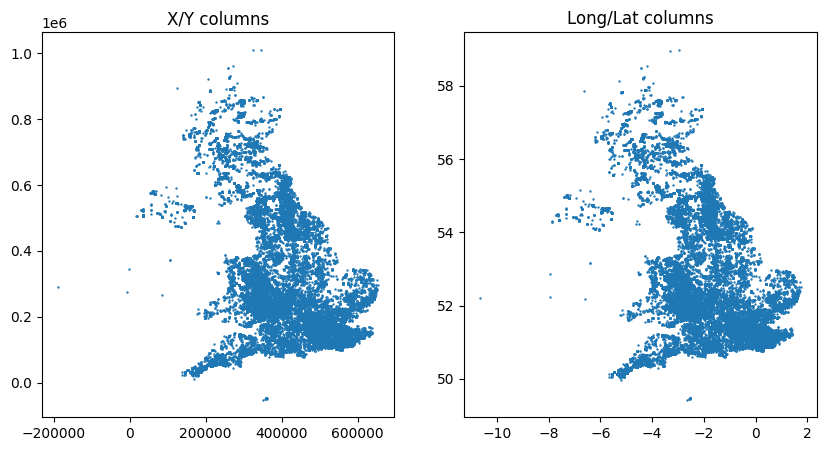

In [8]:
# Are x and y equivalent to Lat/Long? (e.g. perhaps when doing image/shape overlay instead of mapping or using different geo software)?
fig, ax=plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(rawData.x, rawData.y, s=0.5)
ax[1].scatter(rawData.Longitude, rawData.Latitude, s=0.5)
ax[0].set_title('X/Y columns')
ax[1].set_title('Long/Lat columns')

##### Tree Species

Text(0.5, 1.0, '30 Most common species (178 available)')

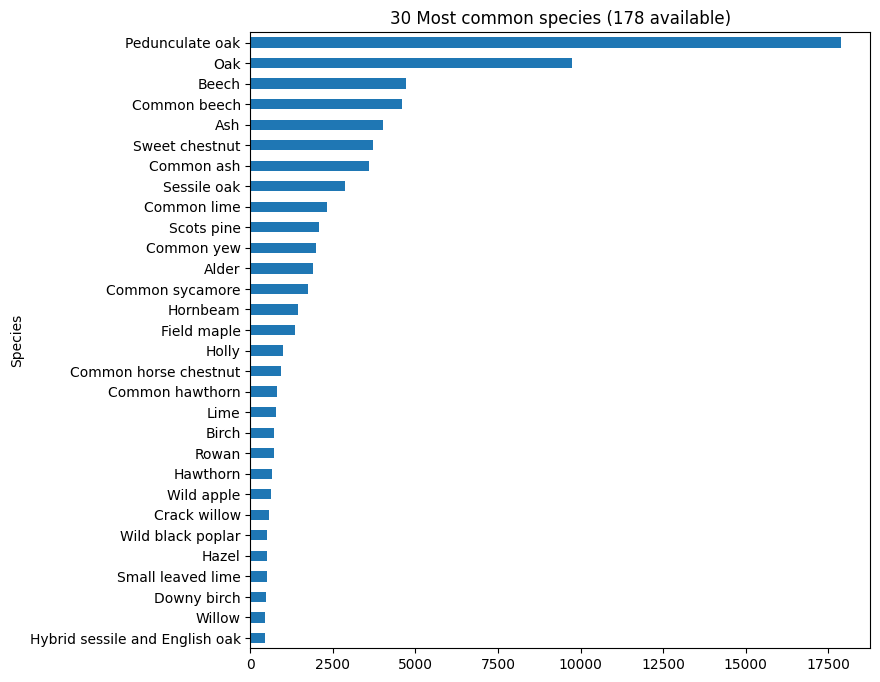

In [6]:
# top 30 species shows rapid drop-off (178 species listed total). Can already see variations of the same tree families being able to group these might be useful in any visual...
rawData['Species'].value_counts(ascending=True)[-30:].plot(kind='barh', figsize=(8,8))
plt.title(f'30 Most common species ({rawData.Species.nunique()} available)')

In [143]:
# Try to identify any higher level tree species groupings by finding common words...
import re
speciesList=pd.DataFrame(rawData.Species.unique(), columns=['speciesraw'])
speciesList.speciesraw=speciesList.speciesraw.str.lower().astype(str)
speciesList.speciesraw=speciesList.speciesraw.apply(lambda x: re.sub(r'[^\w\s]', '',x))
speciesList=pd.concat([speciesList, speciesList.speciesraw.str.split(' ', expand=True)], axis=1)
speciesList=pd.melt(speciesList, id_vars='speciesraw').drop(columns=['variable'])
speciesList=speciesList[(~speciesList.value.isnull())&(speciesList.value.str.len()>1)]
merged=speciesList.merge(speciesList, how='left', on='value')
merged=merged[merged.speciesraw_x!=merged.speciesraw_y].drop_duplicates()

print('Common words in the species listed')
display(merged.value.unique())

exclude_list=['tree', 'common', 'or', 'of', 'and', 'large', 'var', 'white', 'red', 'black','grey', 'silver', 'purple', 'horse', 'wych', 'wild', 'hybrid', 'sessile','monterey', 'lombardy','european', 'norway', 'lombary', 'english','indian', 'caucasian', 'weeping', 'golden', 'leaved', 'puzzle', 'monkey'] # (added retrospectively after first pass of the below method)
merged=merged[~merged.value.isin(exclude_list)]
print('Following review, the below terms are appropriate for an initial higher-level grouping of species names.\nNote this is NOT based on taxonomy, but is a more informal grouping of the tree types listed in the inventory ')
display(merged.value.unique())
species_groups=set(merged.value.unique())

Common words in the species listed


array(['oak', 'beech', 'common', 'cedar', 'white', 'lime', 'walnut',
       'wych', 'ash', 'sessile', 'alder', 'hawthorn', 'willow', 'larch',
       'wild', 'silver', 'elm', 'large', 'hybrid', 'monterey', 'european',
       'poplar', 'cherry', 'black', 'service', 'apple', 'red', 'indian',
       'juniper', 'caucasian', 'mulberry', 'lombardy', 'english', 'birch',
       'grey', 'weeping', 'monkey', 'sycamore', 'maple', 'norway',
       'purple', 'chestnut', 'pear', 'plane', 'cypress', 'plum', 'yew',
       'horse', 'laburnum', 'pine', 'tree', 'golden', 'whitebeam', 'of',
       'leaved', 'or', 'fir', 'puzzle', 'buckthorn', 'and', 'var'],
      dtype=object)

Following review, the below terms are appropriate for an initial higher-level grouping of species names.
Note this is NOT based on taxonomy, but is a more informal grouping of the tree types listed in the inventory 


array(['oak', 'beech', 'cedar', 'lime', 'walnut', 'ash', 'alder',
       'hawthorn', 'willow', 'larch', 'elm', 'poplar', 'cherry',
       'service', 'apple', 'juniper', 'mulberry', 'birch', 'sycamore',
       'maple', 'chestnut', 'pear', 'plane', 'cypress', 'plum', 'yew',
       'laburnum', 'pine', 'whitebeam', 'fir', 'buckthorn'], dtype=object)

In [141]:
def groupSpecies(rowstring, grouplist):
    """Given a list of common species families (data-led not taxonomy-led) and the non-standardised listed species of a tree record, identify the higher family grouping - if any

    Args:
        rowstring (str): listed species of the tree (human-inputted)
        grouplist (list): accepted list of tree families 

    Returns:
        str: identified tree family, or the original species
    """
    # if available, take intersecting term, if not available, take species raw, if more than one term, take last term in species name as that is generally the actual tree type rather than variant
    intersect=[word for word in rowstring.lower().split(' ') if word in grouplist]
    if len(intersect)>1:
        intersect=[intersect[-1]]
    elif len(intersect)==0:
        intersect=[rowstring]
    return str(intersect[0]).capitalize()


Text(0.5, 1.0, 'Detected species groups (31)')

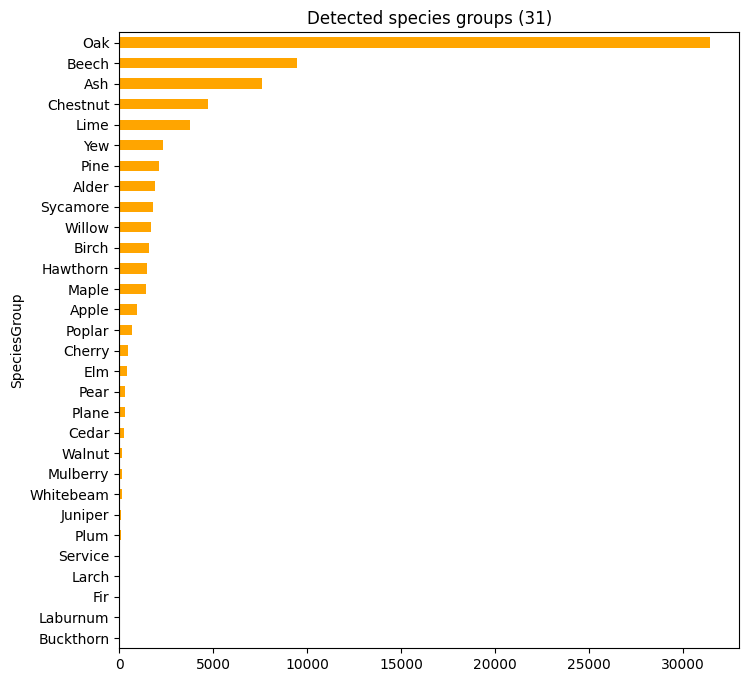

In [147]:
rawData.Species=rawData.Species.fillna('Unknown')
rawData['Species']=np.where(rawData['Species'].str.lower()=='other', 'Unknown',rawData['Species'] )
rawData['SpeciesGroup']=rawData.Species.apply(lambda x:groupSpecies(x, species_groups) )

rawData[rawData.SpeciesGroup.str.lower().isin(species_groups)].SpeciesGroup.value_counts(ascending=True)[-30:].plot(kind='barh', figsize=(8,8), color='orange')
plt.title(f'Detected species groups ({len(species_groups)})')

##### Other Categorical columns

In [207]:
for col in ['StandingStatus', 'LivingStatus', 'PublicAccessibilityStatus', 'TreeForm', 'VeteranStatus',  'Protection', 'SpecialStatus', 'Condition']:
    display(rawData[col].value_counts(dropna=False))

StandingStatus
Standing      75757
Fallen         1964
Fragmented     1357
Remnant         630
Gone            171
NaN              54
Name: count, dtype: int64

LivingStatus
Alive                         75800
Dead                           3484
Chalara fraxinea suspected      218
Felled                          135
Unknown                         128
Chalara fraxinea confirmed       71
Collapsed                        57
Other                            22
Test living status               11
Monitor AOD/COD                   7
Name: count, dtype: int64

PublicAccessibilityStatus
Public - open access                                                      15346
Private - not visible from public access                                   8722
Private - visible from public access                                       8598
Public - partial access (e.g. next to footpath or road)                    8063
Public - partial access                                                    6801
Public - open access (e.g. public park)                                    6543
Public - Scottish Outdoor Access                                           5934
Private - not visible from public access (permission required to view)     5282
Public - restricted access                                                 5269
Private - visible from public access (permission not required to view)     4577
Public - restricted access (e.g. National Trust property)                  2591
Private - no access information recorded                                   1372
Public - no ac

TreeForm
Maiden                    47920
Pollard                   11380
Multi stem                 6149
Coppice                    3088
Pollard lapsed             2757
Pollard form (natural)     2458
Unknown                    1654
Pollard managed            1247
Stump                       931
Multi stem (boundary)       769
Stump (high >4m)            482
Coppice (high stump)        440
Phoenix                     358
Laid(hedgerow)              244
Cliff tree                   54
NaN                           1
Hedgebank                     1
Name: count, dtype: int64

VeteranStatus
Veteran tree         65961
Ancient tree         13371
Lost Veteran tree      490
Lost Ancient tree      111
Name: count, dtype: int64

Protection
NaN                                                  64203
Uncultivated land                                    12966
Fencing                                                814
Conservation Area                                      780
Tree Preservation Order                                519
Uncultivated land,Tree Preservation Order              259
Fencing,Uncultivated land                              202
Uncultivated land,Conservation Area                    137
Fencing,Tree Preservation Order                         21
Fencing,Uncultivated land,Tree Preservation Order       16
Fencing,Uncultivated land,Conservation Area              8
Tree Preservation Order,Conservation Area                5
Fencing,Conservation Area                                3
Name: count, dtype: int64

SpecialStatus
NaN                                                                                                                          70266
Trees of National Special Interest (TNSI)                                                                                     9458
Heritage Tree,Trees of National Special Interest (TNSI)                                                                         80
Trees of National Special Interest (TNSI),Tree of the Year â€“ Shortlisted                                                      28
Heritage Tree,Trees of National Special Interest (TNSI),Tree of the Year â€“ Shortlisted                                        25
Tree of the Year â€“ Shortlisted                                                                                                17
National champion                                                                                                               15
Heritage Tree                                                        

Condition
NaN                                                                                                                                                                                      16419
Decaying wood in the crown                                                                                                                                                                4996
Hollowing trunk                                                                                                                                                                           4242
Holes or water pockets,Hollowing trunk,Hollowing branches,Decaying wood in the crown,Decaying wood on the ground                                                                          3589
Holes or water pockets,Decaying wood in the crown                                                                                                                                         3080
                                   

In [166]:
#It's clear that some of these fields have concatenated data in them - let's split out to see if this is completely free-form or multiple choice...

# How many possible Protection statuses?
protectionSet=set(','.join(rawData[~rawData.Protection.isnull()].Protection.unique()).split(','))
print(f'Protection - {len(protectionSet)} markers')
display(protectionSet)
# How many possible tree awards?
specialSet=set(','.join(rawData[~rawData.SpecialStatus.isnull()].SpecialStatus.unique()).split(','))
print(f'SpecialStatus - {len(specialSet)} markers')
display(specialSet)
# How many possible conditions?
conditionSet=set(','.join(rawData[~rawData.Condition.isnull()].Condition.unique()).split(','))
print(f'Condition - {len(conditionSet)} markers')
display(conditionSet)

# How many possible surroundings?
surrSet=set(','.join(rawData[~rawData.Surroundings.isnull()].Surroundings.unique()).split(','))
print(f'Surroundings - {len(surrSet)} markers')
display(surrSet)

Protection - 4 markers


{'Conservation Area',
 'Fencing',
 'Tree Preservation Order',
 'Uncultivated land'}

SpecialStatus - 8 markers


{'Champion Tree â€“ Countryâ€™s Fattest',
 'Champion Tree â€“ Countyâ€™s Fattest',
 'Champion Tree â€“ UKâ€™s Fattest',
 'Heritage Tree',
 'National champion',
 'Tree of the Year â€“ Shortlisted',
 'Tree of the Year â€“ Winner',
 'Trees of National Special Interest (TNSI)'}

Condition - 12 markers


{'Decaying wood in the crown',
 'Decaying wood in the crown <10%',
 'Decaying wood in the crown <50%',
 'Decaying wood in the crown >50%',
 'Decaying wood in the crown >90%',
 'Decaying wood on the ground',
 'Holes or water pockets',
 'Hollow trunk - with holes <15cm',
 'Hollow trunk - with holes >15cm',
 'Hollow trunk - with opening',
 'Hollowing branches',
 'Hollowing trunk'}

Surroundings - 38 markers


{'Ancient wood pasture',
 'Ancient woodland',
 'Arable',
 'Avenue',
 'Beside railway',
 'Bridlepath / footpath',
 'Cemetery',
 'Churchyard',
 'Common/heath',
 'Cornish or Devon hedge',
 'Deer park',
 'Domestic garden',
 'Field',
 'Hedgerow',
 'Historic Woodbank',
 'Historic park and garden',
 'Landscape garden',
 'Market garden',
 'Mediaeval deer park',
 'Moor Land',
 'Nature Reserve',
 'Orchard',
 'Other',
 'Parish boundary',
 'Parkland',
 'Public or open space',
 'River / canal bank',
 'Roadside',
 'SSSI/NNR/SAC',
 'School / college ground',
 'Tudor deer park',
 'Upland',
 'Urban',
 'Urban Tree',
 'Village green',
 'Wetland',
 'Wood Pasture',
 'Woodland'}

<Axes: ylabel='conditionGroup'>

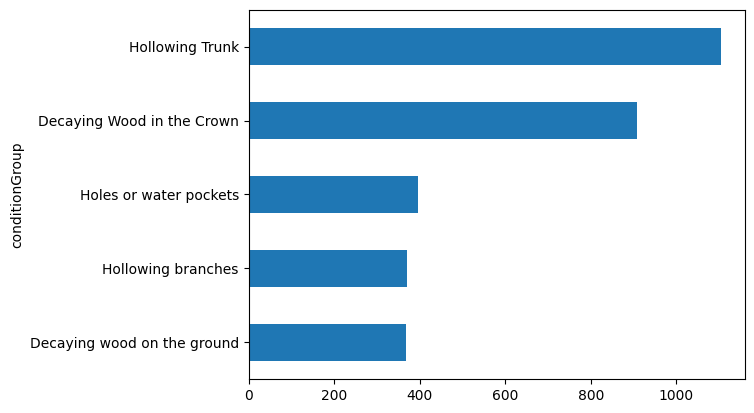

In [231]:
allcondition=pd.DataFrame(','.join(rawData[~rawData.Condition.isnull()].Condition.unique()).split(','), columns=['Condition'])
allcondition['conditionGroup']=allcondition.Condition.apply(lambda x: 'Hollowing Trunk' if ('hollow trunk' in x.lower() or 'hollowing trunk' in x.lower())  else 'Decaying Wood in the Crown' if 'decaying wood in the crown' in x.lower() else x )
allcondition.conditionGroup.value_counts(ascending=True).plot(kind='barh')

In [171]:
# How many possible Epiphyte?
epi=set(','.join(rawData[~rawData.Epiphyte.isnull()].Epiphyte.unique()).split(','))
print(f'Epiphytes - {len(epi)} types, {len(rawData[rawData.Epiphyte.isnull()])} null')
display(epi)

# How many possible Fungus?
fung=set(','.join(rawData[~rawData.Fungus.isnull()].Fungus.unique()).split(','))
print(f'Fungus - {len(fung)} named types, {len(rawData[rawData.Fungus.isnull()])} null')
display(fung)


Epiphytes - 8 types, 35083 null


{'Cuckoo tree',
 'Evidence of',
 'Fern',
 'Ivy',
 'Lichen',
 'Mistletoe',
 'Moss',
 'Other'}

Fungus - 16 named types, 67909 null


{'Beafsteak fungus (Fistulina hepatica)',
 'Beefsteak fungus (Fistulina hepatica)',
 'Birch Polypore/ razorstrop fungus (Piptoporus betulinus)',
 'Blushing bracket (Daedaleopsis confragosa)',
 'Chicken of the woods (Laetiporus sulphureus)',
 'Dryadâ€™s saddle (Polyporus squamosus)',
 "Dyer''s mazegill (Phaeolous schweinitzii)",
 'Evidence of',
 'Giant polypore (Meripilus giganteus)',
 'Oak bracket (Inonotus dryadeus)',
 'Oak bracket (Pseudoinonotus dryadeus)',
 'Other',
 'Shaggy bracket (Inonotus hispidus)',
 'Southern bracket (Ganoderma australe)',
 'Species not listed',
 'Unsure of species'}

##### Create dictionary for any text cleaning required

In [175]:
markerset=specialSet.union(fung).union(surrSet).union(conditionSet).union(epi)
markerset=pd.Series(list(markerset))
import string
letters=list(string.ascii_letters)+[' ']
check=[any([x not in letters for x in each]) for each in markerset]
markerset[check]
# Based on manual review, the following replacements are required: "''"->"'", "â€™" ->"'", "â€“"->"-"

9                    Shaggy bracket (Inonotus hispidus)
11                     Tree of the Year â€“ Shortlisted
13                Beafsteak fungus (Fistulina hepatica)
16                Champion Tree â€“ Countryâ€™s Fattest
23                      Oak bracket (Inonotus dryadeus)
24                      Hollow trunk - with holes >15cm
27                                Bridlepath / footpath
29                 Champion Tree â€“ Countyâ€™s Fattest
32                                         SSSI/NNR/SAC
34                      Decaying wood in the crown <50%
37    Birch Polypore/ razorstrop fungus (Piptoporus ...
38                      Decaying wood in the crown >50%
39                              School / college ground
40                          Hollow trunk - with opening
43                Southern bracket (Ganoderma australe)
46                Oak bracket (Pseudoinonotus dryadeus)
48                          Tree of the Year â€“ Winner
49                      Decaying wood in the cro

##### Date fields

In [97]:
display(len(rawData[rawData.SurveyDate.isnull()]), rawData.SurveyDate.sample(10).unique(), len(rawData[rawData.VerifiedDate.isnull()]), rawData.VerifiedDate.sample(10).unique())

23

array(['7/14/2020 12:00:00 AM', '8/25/2008 12:00:00 AM',
       '11/7/2007 12:00:00 AM', '4/23/2011 12:00:00 AM',
       '3/20/2014 12:00:00 AM', '4/25/2009 12:00:00 AM',
       '4/11/2011 12:00:00 AM', '9/18/2021 12:00:00 AM',
       '2/1/2022 12:00:00 AM', '11/8/2015 12:00:00 AM'], dtype=object)

0

array(['8/7/2011 12:00:00 AM', '6/11/2023 12:00:00 AM',
       '8/18/2013 12:00:00 AM', '7/7/2020 12:00:00 AM',
       '9/18/2022 12:00:00 AM', '8/19/2018 12:00:00 AM',
       '11/7/2016 12:00:00 AM', '7/25/2023 12:00:00 AM',
       '5/30/2021 12:00:00 AM', '6/7/2017 12:00:00 AM'], dtype=object)

min: 1900-01-04 12:00:00, max: 2023-07-28 12:00:00


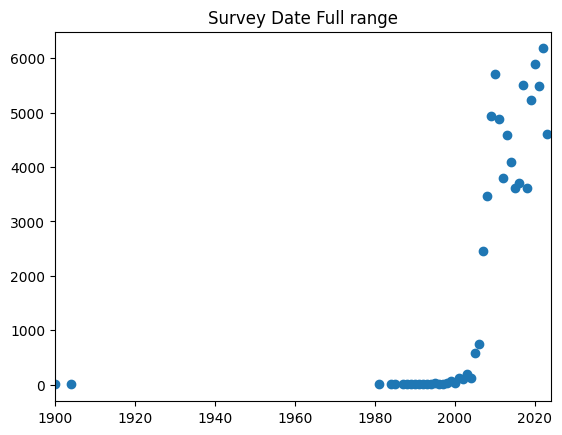

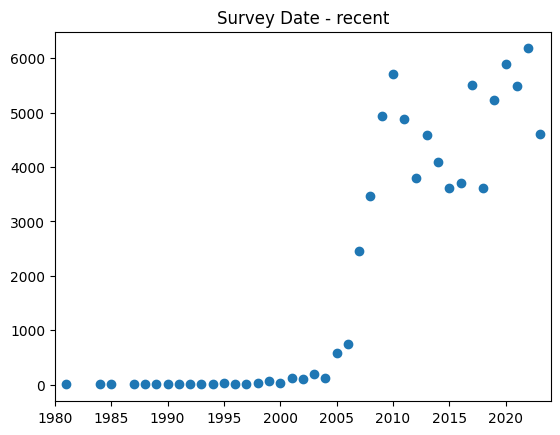

In [99]:
from datetime import datetime as dt
# surveyDate in US format - convert to plot
rawData.SurveyDate=rawData.SurveyDate.fillna('01/01/9999 12:00:00 AM')
rawData['SurveyDate_converted']=rawData.SurveyDate.apply(lambda x: dt.strptime(x, '%m/%d/%Y %H:%M:%S %p'))
print(f'min: {rawData["SurveyDate_converted"].min()}, max: {rawData[rawData.SurveyDate!="01/01/9999 12:00:00 AM"]["SurveyDate_converted"].max()}')

rawData['SurveyDate_year']=rawData.SurveyDate_converted.apply(lambda x: x.year)
_=rawData['SurveyDate_year'].value_counts().reset_index()
l=plt.scatter(x=_.SurveyDate_year, y=_['count'])
plt.xlim( 1900,2024)
plt.title('Survey Date Full range')
plt.show()

l=plt.scatter(x=_.SurveyDate_year, y=_['count'])
l=plt.xlim(1980, 2024)
plt.title('Survey Date - recent')
plt.show()

In [102]:
display(rawData[rawData.SurveyDate_year<1910].RecorderOrganisationName,rawData[rawData.SurveyDate_year<1910])
# No indication whether these were truly recorded in 1904 - can speculate as to how these records were added, but given verification date we know they are accurate tree records.
# Unlikely to be focussing on survey date too much, and this is only two records anyway

211      Shropshire Countryside Service
19773                    National Trust
Name: RecorderOrganisationName, dtype: object

,OBJECTID,Id,SurveyDate,VerifiedDate,MeasuredGirth,MeasuredHeight,EstimatedGirth,Latitude,Longitude,GridReference,...,Condition,Surroundings,Protection,SpecialStatus,Epiphyte,Fungus,x,y,SurveyDate_converted,SurveyDate_year
211,212,360,1/1/1904 12:00:00 AM,3/5/2021 12:00:00 AM,5.85,1.5,False,52.882059,-2.967055,SJ3502032060,...,NaN,Hedgerow,NaN,NaN,NaN,NaN,335019.906398,332058.416281,1904-01-01 12:00:00,1904
19773,19774,80974,1/4/1900 12:00:00 AM,4/28/2011 12:00:00 AM,7.63,1.5,False,52.287391,-2.820638,SO44126579,...,NaN,Field,NaN,Trees of National Special Interest (TNSI),NaN,NaN,344120.014045,265788.633247,1900-01-04 12:00:00,1900


min: 2007-02-06 12:00:00, max: 2023-07-28 12:00:00


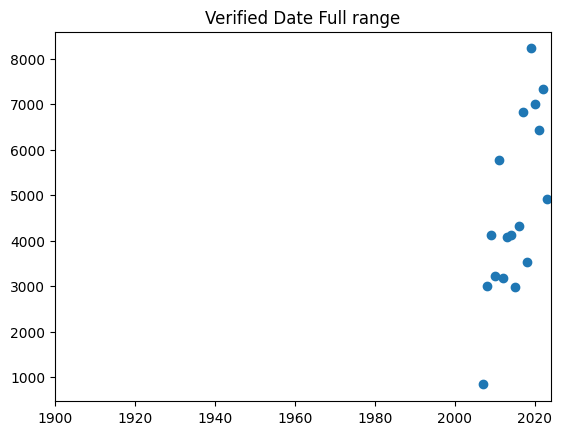

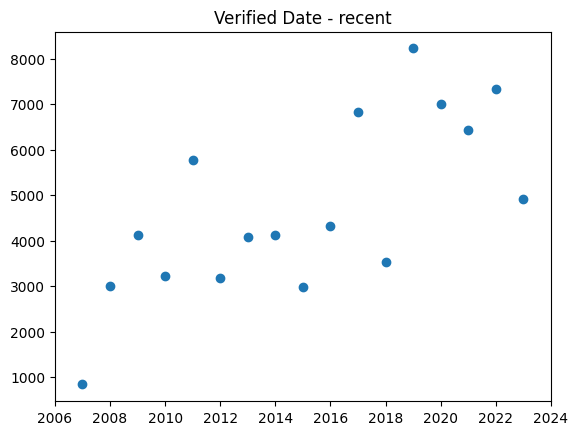

In [90]:
from datetime import datetime as dt
# VerifiedDate in US format - convert to plot
rawData.VerifiedDate=rawData.VerifiedDate.fillna('01/01/9999 12:00:00 AM')
rawData['VerifiedDate_converted']=rawData.VerifiedDate.apply(lambda x: dt.strptime(x, '%m/%d/%Y %H:%M:%S %p'))
print(f'min: {rawData["VerifiedDate_converted"].min()}, max: {rawData[rawData.VerifiedDate!="01/01/9999 12:00:00 AM"]["VerifiedDate_converted"].max()}')

rawData['VerifiedDate_year']=rawData.VerifiedDate_converted.apply(lambda x: x.year)
_=rawData['VerifiedDate_year'].value_counts().reset_index()
l=plt.scatter(x=_.VerifiedDate_year, y=_['count'])
plt.xlim( 1900,2024)
plt.title('Verified Date Full range')
plt.show()

l=plt.scatter(x=_.VerifiedDate_year, y=_['count'])
l=plt.xlim(2006, 2024)
plt.title('Verified Date - recent')
plt.show()

### Observations
- Granularity is at the Id/objectId level. These two are not identical but are both unique identifiers, always numerical
- X/Y columns appear to be a linear conversion of Long/Lat. Potential to use for overlay over image/shape if opting not to usestandard mapping functions
- Cleaning required on Country - particularly Northern Ireland /N. Ireland, County Wicklow (RoI), and Braddan (Isle of Man). Some of this will impact County too.
- Town is majority null, however Long/Lat and County are fully/very well populated respectively. When creating mapped or summary visuals, we are unlikely to find Town useful as the level of detail is highly varied (sometimes a hamlet, sometimes a city name). As a result, let's focus on fetching missing Counties so that we can summarise in both mapping and other visuals.
- High-level grouping on species is possible - this is not a restricted field so inconsistencies
- Living status - high level grouping possible, and can be used to derive Ash die-back flag
- Public accessibility - derive dimple Public/private high level flag
- Protection status - could be pivoted to form separate binary flags: Conservation Area, Tree Preservation Order, etc. Vast majority have no listed protection
- Replace NaNs: StandingStatus, PublicAccessibilityStatus, Protection, Special Status
- SpecialStatus - 8 different possible values, concatenated. Rather than introducing 8 more columns, we could build a separate un-pivoted table including only trees which have special status, with one row per accolade per tree. Vast majority have no listed special status
- Condition - 12 possible mrkers, concatenated. These can also be grouped to higher levels. Roughly 3/4 have conditions listed
- Fungus - cleaning required, some mispelled duplicates. Vast majority null.
- Epiphytes - 50% null
- Date fields are in US format (mm/dd/yyyy) and timestamp value does not add any detail (always 12AM). Nulls need to be filled
- Verficiation starts in 2007, this may be an accurate representation of 'work' on the ATI, likely that records coming in have been digitised at some point since then. Surveydate may be used to reflect awareness / 'citizen' input by contrast.
- Ancient Tree Inventory website states over 180k trees already listed, however there are ~80k records in the download file. This may indicate that only 80k have been officially verified (which is presumably a manual process - all records in this dataset have a verification date), or that some of the 180k are duplicates - which is perfectly possible given that this is a citizen science project with anyone able to contribute a record.

### County / Regional Aggregation EDA

##### Scraping counties lists
Can we use a list of 'correct' counties to build a lookup or other approach to correcting raw data?


In [129]:
import io
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
# Get list of Counties to check against
url = 'https://en.wikipedia.org/wiki/List_of_counties_of_the_United_Kingdom'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')
tablewiki = io.StringIO(str(soup.find_all('table')))
#note slightly different table format for scotland. England list includes too many historical which aren't possible to scrape (due to use of ticks instaead of text)
all_counties_wiki = pd.concat([ pd.read_html(tablewiki)[1].County.County, pd.read_html(tablewiki)[2].County.County, pd.read_html(tablewiki)[3].County, pd.read_html(tablewiki)[4].County.County], axis=0)
# wiki data not particularly useful for England - many non-standard or ceremonial counties, no easy way to filter as the information is stored in tick icons which aren't pulled through inscrape

#take non-England counties
s_ni_w_counties=pd.concat([ pd.read_html(tablewiki)[2].County.County, pd.read_html(tablewiki)[3].County, pd.read_html(tablewiki)[4].County.County], axis=0)

#alternative source for England counties
url = 'https://www.visitnorthwest.com/counties/'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')
table = io.StringIO(str(soup.find_all('table')))
uk_counties=pd.read_html(table)[0].County

#create combined table
all_counties=pd.concat([uk_counties, s_ni_w_counties])
all_counties=list(all_counties)
all_counties


['Bedfordshire',
 'Berkshire',
 'Bristol',
 'Buckinghamshire',
 'Cambridgeshire',
 'Cheshire',
 'City of London',
 'Cornwall',
 'Cumbria',
 'Derbyshire',
 'Devon',
 'Dorset',
 'Durham',
 'East Riding of Yorkshire',
 'East Sussex',
 'Essex',
 'Gloucestershire',
 'Greater London',
 'Greater Manchester',
 'Hampshire',
 'Herefordshire',
 'Hertfordshire',
 'Isle of Wight',
 'Kent',
 'Lancashire',
 'Leicestershire',
 'Lincolnshire',
 'Merseyside',
 'Norfolk',
 'North Yorkshire',
 'Northamptonshire',
 'Northumberland',
 'Nottinghamshire',
 'Oxfordshire',
 'Rutland',
 'Shropshire',
 'Somerset',
 'South Yorkshire',
 'Staffordshire',
 'Suffolk',
 'Surrey',
 'Tyne and Wear',
 'Warwickshire',
 'West Midlands',
 'West Sussex',
 'West Yorkshire',
 'Wiltshire',
 'Worcestershire',
 'Antrim',
 'Armagh',
 'City of Belfast',
 'Down',
 'Fermanagh',
 'Londonderry',
 'City of Derry',
 'Tyrone',
 'City of Aberdeen',
 'Aberdeenshire',
 'Angus (Forfarshire)',
 'Argyll',
 'Ayrshire',
 'Banffshire',
 'Berwickshi

##### Study reverse-geocoding approaches to fetch County based on Lat/Long
##### reverse geo-coding with reverse_geocoder package

In [140]:
import reverse_geocoder as rg

search_coords=list(zip(rawData.Latitude, rawData.Longitude))
results = rg.search(search_coords) 
results=pd.DataFrame(results)
results=pd.concat([rawData.reset_index(drop=True), pd.DataFrame(results)], axis=1)
results.columns

Index(['OBJECTID', 'Id', 'SurveyDate', 'VerifiedDate', 'MeasuredGirth',
       'MeasuredHeight', 'EstimatedGirth', 'Latitude', 'Longitude',
       'GridReference', 'Species', 'TreeForm', 'RecorderOrganisationName',
       'LocalName', 'Town', 'County', 'Country', 'StandingStatus',
       'LivingStatus', 'PublicAccessibilityStatus', 'VeteranStatus',
       'Condition', 'Surroundings', 'Protection', 'SpecialStatus', 'Epiphyte',
       'Fungus', 'x', 'y', 'SurveyDate_converted', 'SurveyDate_year', 'lat',
       'lon', 'name', 'admin1', 'admin2', 'cc'],
      dtype='object')

In [136]:
results[['Latitude', 'Longitude', 'Town', 'County', 'name', 'admin1', 'admin2', 'cc']].sample(20)

,Latitude,Longitude,Town,County,name,admin1,admin2,cc
34898,52.355457,-2.828418,NaN,Herefordshire,Downton,England,Herefordshire,GB
39381,50.849012,-1.582855,NaN,Hampshire,Lyndhurst,England,Hampshire,GB
41637,51.839897,-2.653190,NaN,Herefordshire,Whitchurch,England,Herefordshire,GB
60742,54.039260,-1.536633,Nidd,North Yorkshire,Harrogate,England,North Yorkshire,GB
72413,52.098494,-1.595574,Idlicote,Warks,Shipston on Stour,England,Warwickshire,GB
2211,54.683019,-6.764902,NaN,Londonderry,Cookstown,Northern Ireland,Cookstown District,GB
49390,51.877185,-2.979478,NaN,Sir Fynwy - Monmouthshire,Llancillo,England,Herefordshire,GB
17454,51.986467,1.113854,NaN,Suffolk,Mistley,England,Essex,GB
25686,55.658716,-2.269689,NaN,Scottish Borders,Coldstream,Scotland,The Scottish Borders,GB
25765,55.346159,-3.973650,NaN,Dumfries and Galloway,Kirkconnel,Scotland,Dumfries and Galloway,GB


In [139]:
to_correct=rawData[(~rawData.County.isin(all_counties))&(rawData.Country.isin(['England', 'Scotland', 'Northern Ireland', 'Wales']))]
search_coords=list(zip(to_correct.Latitude, to_correct.Longitude))
results = rg.search(search_coords) 
results=pd.DataFrame(results)
results=pd.concat([to_correct[['Id', 'Town', 'County', 'Country']].reset_index(drop=True), pd.DataFrame(results)], axis=1)
results[results.admin1!='England'].admin2.unique()
results.sample(20)

,Id,Town,County,Country,lat,lon,name,admin1,admin2,cc
13257,213152,Draycott,Glos,England,52.04964,-1.7767,Chipping Campden,England,Gloucestershire,GB
13755,215349,Denny Lodge,Hants,England,50.87259,-1.57662,Lyndhurst,England,Hampshire,GB
13886,216496,NaN,Glos,England,51.95363,-1.96398,Winchcombe,England,Gloucestershire,GB
14938,223245,Nethercote,Oxon,England,52.0632,-1.34222,Banbury,England,Oxfordshire,GB
13727,215239,Jedburgh,Scottish Borders,Scotland,55.47997,-2.552,Jedburgh,Scotland,The Scottish Borders,GB
4155,102141,New Forest,Hants,England,50.8465,-1.79214,Ringwood,England,Hampshire,GB
6291,138746,NaN,Dumfries and Galloway,Scotland,55.15101,-2.99889,Langholm,Scotland,Dumfries and Galloway,GB
13876,216462,Denny Lodge,Hants,England,50.88966,-1.4544,Marchwood,England,Hampshire,GB
6905,146066,NaN,Aberdeen,Scotland,57.14369,-2.09814,Aberdeen,Scotland,Aberdeen City,GB
12431,207192,Steeple Barton,Oxon,England,51.9806,-1.32055,Deddington,England,Oxfordshire,GB


##### Reverse geo-coding using rg is time-efficient, and useful to replcae cases where County is in abbreviated form etc. However, in cases where the original County doesn't exist in the all-counties lookup, we don't always get any correction. This might be more of a reflection on the all-counties lookup quality...
##### Note - at this point, trials in Tableau showed that the counties information being returned is not always recognised

##### Trial reverse Geo-coding with Geopy package, OpenCage module

In [ ]:
from geopy import OpenCage
mykey='a668eabbc20d47edaccf063af684c52e'
geocage=OpenCage(api_key=mykey)
geocage.reverse('51.577949,-4.0412843').raw

{'annotations': {'DMS': {'lat': "51° 34' 40.97856'' N",
   'lng': "4° 2' 29.20056'' W"},
  'MGRS': '30UVC2783414623',
  'Maidenhead': 'IO71xn58ar',
  'Mercator': {'x': -449891.554, 'y': 6690690.414},
  'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=261739454#map=17/51.57805/-4.04144',
   'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.57805/-4.04144&layers=N',
   'url': 'https://www.openstreetmap.org/?mlat=51.57805&mlon=-4.04144#map=17/51.57805/-4.04144'},
  'UN_M49': {'regions': {'EUROPE': '150',
    'GB': '826',
    'NORTHERN_EUROPE': '154',
    'WORLD': '001'},
   'statistical_groupings': ['MEDC']},
  'callingcode': 44,
  'currency': {'alternate_symbols': [],
   'decimal_mark': '.',
   'html_entity': '&#x00A3;',
   'iso_code': 'GBP',
   'iso_numeric': '826',
   'name': 'British Pound',
   'smallest_denomination': 1,
   'subunit': 'Penny',
   'subunit_to_unit': 100,
   'symbol': '£',
   'symbol_first': 1,
   'thousands_separator': ','},
  'flag': '🇬🇧',
  'g

##### ^ County available, but slower to fetch and limit on number of API calls

##### Create lookup to correct County based on text

In [ ]:
## Generate lookup for common mispellings/miscategorisations for County

treeData=rawData.copy()

# create boolean flags for fields with markers
markerDict={'Protection':',','Epiphyte':',', 'Fungus':',', 'Condition':',', 'SpecialStatus':',', 'Surroundings':',' }
createBoolFlag(treeData, markerDict)

# Null handling for specific fields - Unknown
fillna_fields=['StandingStatus', 'LivingStatus', 'PublicAccessibilityStatus', 'Protection', 'SpecialStatus', 'Town', 'TreeForm', 'County', 'Country']
fillnans(treeData, fillna_fields)

# enforce data types
typeDict={
'Id': int , 
'Species': str, 
'TreeForm': str, 
'RecorderOrganisationName': str,
'LocalName': str, 
'Town': str, 
'County': str, 
'Country': str, 
'StandingStatus': str,
'LivingStatus': str, 
'PublicAccessibilityStatus': str, 
'VeteranStatus': str,
'Condition': str, 
'Surroundings': str, 
'Protection': str, 
'SpecialStatus': str, 
'Epiphyte': str,
'Fungus': str}

typeCheck(treeData, typeDict)

#to_correct=rawData[~rawData.County.isin(all_counties)].copy()
to_correct=treeData.groupby('County').sample(1)
to_correct['County_original']=to_correct.County
to_correct=to_correct.apply(lambda x: getLocation(x, geolocator, []), axis=1)
countydict={'Durham': 'County Durham', '&': 'and', 'amp;':''}
countrydict={'German': 'Germany', 'Éire / Ireland':'Republic of Ireland','Tuaisceart Éireann / Northern Ireland':'Northern Ireland', 'Cymru / Wales': 'Wales', 'Alba / Scotland': 'Scotland', 'Ellan Vannin / Isle of Man':'Isle of Man'}
to_correct['County']=to_correct.County.replace(countydict, regex=True)
to_correct['Country']=to_correct.Country.replace(countrydict, regex=True)
to_correct['Country_HL']=np.where(to_correct.Country.isin( ['England', 'Scotland', 'Northern Ireland', 'Wales', 'Isle of Man']), 'United Kingdom', to_correct.Country)
lookup_dict=','.join(to_correct.apply(lambda x: "'"+x.County_original+"': '"+x.County+"'", axis=1))

Boolean flags generated for Protection, Epiphyte, Fungus, Condition, SpecialStatus, Surroundings
Null handling complete
Type conversion complete


In [ ]:
# download for manual review
to_correct[['County', 'Country', 'Country_HL', 'County_original', 'Latitude', 'Longitude']].to_csv('../Data/AncientTrees/lookupcheck.csv', index=False)

In [ ]:
rawData['County_new']=rawData.County
rawData.County_new=rawData.County_new.replace(lookup_dict, regex=True)
rawData.County.nunique(), rawData.County_new.nunique()

(226, 226)

In [ ]:
lookup_dict

"'Aberdeen': 'Unknown','Aberdeen City': 'Unknown','Aberdeenshire': 'Aberdeenshire','Abertawe - Swansea': 'Swansea','Angus': 'Angus','Antrim': 'County Antrim','Antrim & Newtownabbey': 'Antrim and Newtownabbey','Antrim &amp; Newtownabbey': 'Antrim and Newtownabbey','Argyll and Bute': 'Argyll and Bute','Armagh': 'County Armagh','Barnsley': 'Unknown','Bath and North East Somerset': 'Bath and North East Somerset','Bedford Borough': 'Bedford','Bedfordshire': 'Bedford','Beds': 'Central Bedfordshire','Belfast City': 'Belfast City','Berkshire': 'West Berkshire','Birmingham': 'Unknown','Blackburn with Darwen': 'Blackburn with Darwen','Blackpool': 'Blackpool','Blaenau Gwent': 'Blaenau Gwent','Bournemouth': 'Bournemouth, Christchurch and Poole','Bracknell Forest': 'Bracknell Forest','Braddan': 'Braddan','Bradford': 'Unknown','Bridgend': 'Bridgend','Brighton and Hove': 'Brighton and Hove','Bristol': 'City of Bristol','Bro Morgannwg - Vale of Glamorgan': 'Vale of Glamorgan','Buckinghamshire': 'Bucki

##### Based on two key factors - 1) the difficulty of securing a 'fact' list of acceptable county names and replacing these consistenly in the dataset and 2) ensuring all the output counties are mappable in Tableau, which does not recognise many UK counties by name - our best approach for any regional mapping analytics is to specify polygons which we want to roll-up by. In Tableau, we have the option of aligning this with the NUTs Europe list, which is one of the auto-geo field options available out of the box. This is a well-maintained official geo-representation (https://ec.europa.eu/eurostat/web/nuts/nuts-maps).

In Power BI, we have convenient options to add our own shapefiles (as topojson files) to ensure the value counts align with the geographic representation. 

##### Region Allocation using Shapefiles

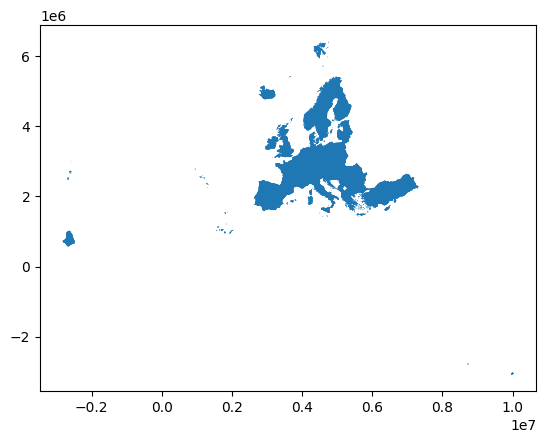

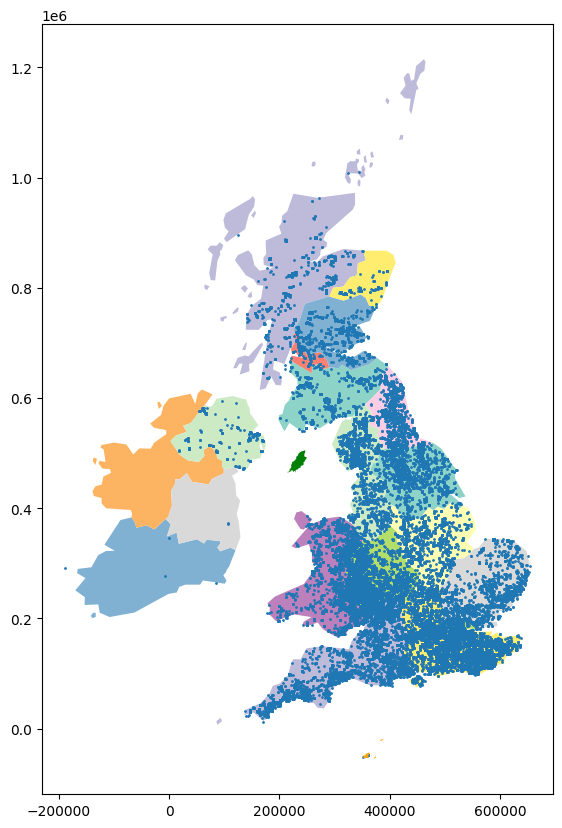

In [176]:
import geopandas as gpd
# Europe-wide NUTs (2021) of all levels available from 'https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts'
shape=gpd.read_file('C:/Users/helen/Documents/Python/Data/AncientTrees/All_Nuts_2021/NUTS_RG_20M_2021_3035.shp')
shape.plot()
nuts_Combo=shape[(((shape.CNTR_CODE=='IE')|(shape.NUTS_ID.str.contains('UKM')))&(shape.LEVL_CODE==2))|((shape.CNTR_CODE=='UK')&(shape.LEVL_CODE==1)&(shape.NUTS_ID!='UKM'))].reset_index()

# Change projection so that it matches the x/y available in tree data (as-is = EPSG:3035, target = ESPG:2700, British National Grid)
nuts_Combo.crs='EPSG:3035'
nuts_Combo=nuts_Combo.to_crs('EPSG:27700')
# load tree data points into geometries
gdf = gpd.GeoDataFrame(rawData[['Id', 'Latitude', 'Longitude']], geometry= gpd.points_from_xy(rawData.x, rawData.y))
gdf.crs='EPSG:27700'
#gdf=gdf.to_crs('EPSG:4258')
# Isle of Man shapefile from 'https://maps.princeton.edu/catalog/stanford-nk743nh6214'
IoM=gpd.read_file('C:/Users/helen/Downloads/stanford-nk743nh6214-shapefile/nk743nh6214.shp')
#Guernsey https://maps.princeton.edu/catalog/stanford-bk868xv4713
Guernsey=gpd.read_file('C:/Users/helen/Downloads/data/GGY_adm0.shp')

fig, ax=plt.subplots(1,1, figsize=(10,10))
#nuts_Combo=nuts_Combo.sort_values(by='NUTS_ID')
nuts_Combo=nuts_Combo.sample(frac=1).reset_index(drop=True)
nuts_Combo.plot( ax=ax,  cmap="Set3")
# check alignment with crs of NUTs otherwise the polygon within won't work
gdf.plot(ax=ax, markersize=1)

IoM.crs='EPSG:4326'
IoM=IoM.to_crs('EPSG:27700')
IoM.plot(color='green', ax=ax)
Guernsey.crs='EPSG:4326'
Guernsey=Guernsey.to_crs('EPSG:27700')
Guernsey.plot(color='orange',ax=ax)

#Combine into one list
nutscols=['NUTS_ID', 'CNTR_CODE', 'NUTS_NAME', 'geometry']
IoM=IoM.rename(columns={'name_fao': 'NUTS_NAME', 'iso':'NUTS_ID'})
IoM['CNTR_CODE']=IoM.NUTS_ID
Guernsey=Guernsey.rename(columns={'NAME_ENGLI': 'NUTS_NAME', 'ISO':'NUTS_ID'})
Guernsey['CNTR_CODE']=Guernsey.NUTS_ID

nuts_Combo=pd.concat([nuts_Combo[nutscols], IoM[nutscols], Guernsey[nutscols]],ignore_index=True, axis=0)


In [36]:
nuts_Combo

,NUTS_ID,CNTR_CODE,NUTS_NAME,geometry
0,UKM7,UK,Eastern Scotland,"POLYGON ((374089.823 762699.928, 364173.509 74..."
1,UKD,UK,North West (England),"POLYGON ((380032.896 544065.643, 378167.515 53..."
2,UKM5,UK,North Eastern Scotland,"POLYGON ((374089.823 762699.928, 368667.188 76..."
3,UKK,UK,South West (England),"MULTIPOLYGON (((423051.510 232167.875, 421725...."
4,UKH,UK,East of England,"POLYGON ((579405.740 195605.037, 594805.877 19..."
5,UKF,UK,East Midlands (England),"POLYGON ((533831.189 405082.232, 544258.426 39..."
6,IE04,IE,Northern and Western,"MULTIPOLYGON (((64588.240 587361.710, 39026.74..."
7,UKM6,UK,Highlands and Islands,"MULTIPOLYGON (((455896.843 1188479.951, 448293..."
8,UKM8,UK,West Central Scotland,"POLYGON ((265895.215 681558.436, 274205.578 68..."
9,UKJ,UK,South East (England),"MULTIPOLYGON (((496534.297 246753.349, 492636...."


In [19]:
#gdf = gpd.GeoDataFrame(rawData[['Id', 'Latitude', 'Longitude']], geometry= gpd.points_from_xy(rawData.x, rawData.y))
gdf['NUTS_ID']='N/A'
generate_df=pd.DataFrame(columns=gdf.columns)

for each in range(len(nuts_Combo)):
    polygon=nuts_Combo.loc[each, 'geometry']
    poly_id=nuts_Combo.loc[each, 'NUTS_ID']
    out=gdf.geometry.within(polygon)
    gdf.loc[out, 'NUTS_ID']=poly_id
    generate_df=pd.concat([generate_df, gdf[out]], axis=0)
    gdf=gdf.loc[~out].copy()


#get those which are null based on the closest polygon (generally nulls are just outside the official NUTs geometries on the coast)
for each in range(len(nuts_Combo)):
    polygon=nuts_Combo.loc[each, 'geometry']
    poly_id=nuts_Combo.loc[each, 'NUTS_ID']
    gdf[poly_id]=gdf.geometry.distance(polygon)

gdf['NUTS_ID']=gdf[nuts_Combo.NUTS_ID.unique()].idxmin(axis="columns")
gdf

# add any locations which have null NUTS (e.g. Isle of man, RoI, Guernsey)
generate_df=pd.concat([generate_df, gdf[generate_df.columns]], axis=0)
generate_df=generate_df.merge(nuts_Combo[['NUTS_NAME', 'NUTS_ID']], on='NUTS_ID', how='left')
generate_df[['NUTS_NAME', 'NUTS_ID']].value_counts()


C:\Users\helen\AppData\Local\Temp\ipykernel_11380\4101787033.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  generate_df=pd.concat([generate_df, gdf[out]], axis=0)


NUTS_NAME                 NUTS_ID
South East (England)      UKJ        19231
South West (England)      UKK        12341
West Midlands (England)   UKG        10948
Wales                     UKL        5592 
East of England           UKH        4784 
Yorkshire and the Humber  UKE        4683 
East Midlands (England)   UKF        4560 
North West (England)      UKD        3830 
North East (England)      UKC        3265 
Eastern Scotland          UKM7       2865 
Southern Scotland         UKM9       2526 
London                    UKI        2004 
Highlands and Islands     UKM6       1941 
Northern Ireland          UKN        643  
North Eastern Scotland    UKM5       413  
West Central Scotland     UKM8       282  
Guernsey                  GGY        10   
Northern and Western      IE04       6    
Southern                  IE05       4    
Isle of Man               IMN        3    
Eastern and Midland       IE06       2    
Name: count, dtype: int64

##### Prep shapefile for PowerBI

In [ ]:
import topojson as tp
import datetime as dt
# Change projection so that it matches the x/y available in tree data (as-is = EPSG:3035, target = ESPG:2700, British National Grid)

nuts_Combo=nuts_Combo.to_crs('EPSG:4258') # for PowerBI
now=dt.datetime.now().strftime("%d-%m-%Y_%H%M")
topo=tp.Topology(nuts_Combo,  topology=False)
topo.to_json(f'../Data/AncientTrees/NUTs_topology_{now}.json')

<Axes: >

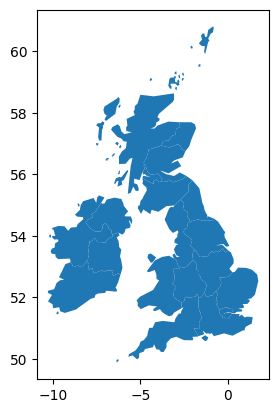

In [ ]:
nuts_Combo.plot()

<Axes: >

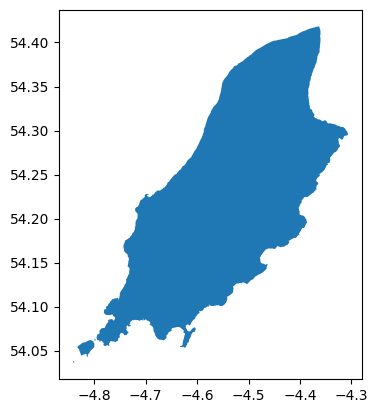

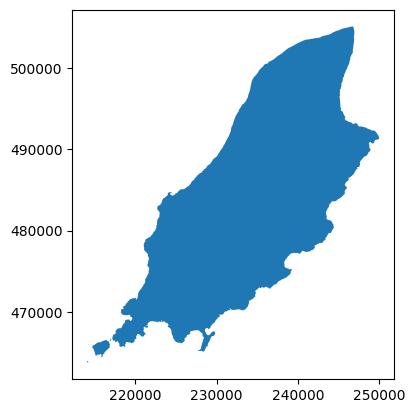

In [ ]:
import geopandas as gpd
# Isle of Man shapefile from 'https://maps.princeton.edu/catalog/stanford-nk743nh6214'
IoM=gpd.read_file('C:/Users/helen/Downloads/stanford-nk743nh6214-shapefile/nk743nh6214.shp')
IoM.plot()
IoM.crs='EPSG:4326'
IoM=IoM.to_crs('EPSG:27700')
IoM.plot()

In [ ]:
nutscols=['NUTS_ID', 'CNTR_CODE', 'NUTS_NAME', 'geometry']
nuts_Combo

,index,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,187,UKJ,1,UK,South East (England),South East (England),0.0,0,0,UKJ,"MULTIPOLYGON (((-0.59177 52.11069, -0.65295 51..."
1,188,UKK,1,UK,South West (England),South West (England),0.0,0,0,UKK,"MULTIPOLYGON (((-1.66573 51.98749, -1.68710 51..."
2,189,UKL,1,UK,Wales,Wales,0.0,0,0,UKL,"MULTIPOLYGON (((-2.72682 52.98330, -2.77673 52..."
3,191,UKN,1,UK,Northern Ireland,Northern Ireland,0.0,0,0,UKN,"POLYGON ((-5.97653 55.05660, -5.96388 54.98418..."
4,227,UKC,1,UK,North East (England),North East (England),0.0,0,0,UKC,"POLYGON ((-1.22922 54.58489, -1.21535 54.58084..."
5,228,UKD,1,UK,North West (England),North West (England),0.0,0,0,UKD,"POLYGON ((-2.31204 54.79108, -2.34025 54.69505..."
6,229,UKE,1,UK,Yorkshire and the Humber,Yorkshire and the Humber,0.0,0,0,UKE,"POLYGON ((-0.79091 54.55948, -0.56227 54.46373..."
7,230,UKF,1,UK,East Midlands (England),East Midlands (England),0.0,0,0,UKF,"POLYGON ((0.01738 53.52537, 0.17147 53.46233, ..."
8,231,UKG,1,UK,West Midlands (England),West Midlands (England),0.0,0,0,UKG,"POLYGON ((-1.59751 52.70043, -1.58961 52.68727..."
9,232,UKH,1,UK,East of England,East of England,0.0,0,0,UKH,"POLYGON ((0.59077 51.63065, 0.81148 51.60088, ..."


In [ ]:
shape

,id_0,iso,name_engli,name_iso,name_fao,name_local,name_obsol,name_varia,name_nonla,name_frenc,...,caricom,eu,can,acp,landlocked,aosis,sids,islands,ldc,geometry
0,110.0,IMN,Isle of Man,ISLE OF MAN,Isle of Man,Isle of Man,NaN,Man,NaN,Île de Man,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-4.83868 54.03650, -4.84009 54..."
